# Deep Learning: Coursework 3

------------------------------------------------------

**Student Name:**  Jeremy Dang (Student Number: 17097407 )

**Start date:** *26th March 2019*

**Due date:** *29th April 2019, 09:00 am *

------------------------------------------------------


## How to Submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_DL_cw3.ipynb** before the deadline above.

Please produce a **pdf** with all the **results** (tables and plots) as well as the **answers** to the questions below. For this assignment, you don't need to include any of the code in the pdf, but answers to the questions should be self-contained and should not rely on a code reference.  **Page limit: 20 pg.**

### IMPORTANT
Please make sure your submission includes **all results/answers/plots/tables** required for grading. We should not have to re-run your code.

### Credits
A special thank you to Mihaela Rosca, Shakir Mohammend and Andriy Mnih for their help in this coursework.

# Assignment Description 
(Latent Generative Models)


## Topics and optimization techniques covered: 

* Stochastic variational inference
* Amortized variational inference (VAEs)
* Improving amortized variational inference using KL annealing
* Improving amortized variational inference using constraint optimization
* Avoiding latent space distribution matching using GANs


## Tensorflow

**Note: ** Before taking on this assignment you might find it useful to take a look at the `tensorflow_probability` [package](https://www.tensorflow.org/probability), especially if you have not used probability distributions in TensorFlow before. In this assignment we will use only standard probability distribtions (like Gaussian and Bernouli), but worth taking a look on how TF handles in-graph sampling and optimizations involving distributions.

In [0]:
#@title Imports (Do not modify!)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

# Tensorflow probability utilities
import tensorflow_probability as tfp

tfd = tfp.distributions

import warnings
warnings.filterwarnings('ignore')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
#@title Check you're using the GPU (Expand me for instructions)
# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Helper Functions for visualisation


In [0]:
def gallery(array, ncols=10, rescale=False):
    """Data visualization code."""
    if rescale:
      array = (array + 1.) / 2
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

In [0]:
def show_digits(axis, digits, title=''):
  axis.axis('off')
  ncols = int(np.sqrt(digits.shape[0]))
  axis.imshow(gallery(digits, ncols=ncols).squeeze(axis=2), 
                 cmap='gray')
  axis.set_title(title, fontsize=15)

In [0]:
def show_latent_interpolations(generator, prior, session):
  a = np.linspace(0.0, 1.0, BATCH_SIZE)
  a = np.expand_dims(a, axis=1)

  first_latents = prior.sample()[0]
  second_latents = prior.sample()[0]

  # To ensure that the interpolation is still likely under the Gaussian prior,
  # we use Gaussian interpolation - rather than linear interpolation.
  interpolations =  np.sqrt(a) * first_latents + np.sqrt(1 - a) * second_latents

  ncols = int(np.sqrt(BATCH_SIZE))
  samples_from_interpolations = generator(interpolations)
  samples_from_interpolations_np = sess.run(samples_from_interpolations)
  plt.gray()
  axis = plt.gca()
  show_digits(
     axis, samples_from_interpolations_np, title='Latent space interpolations')

## Hyperparameters (Do not modify!)
These were chosen to work across all models you are going to be training. At times you will need to explore other configuration to answer the questions, but keep this as default -- things should train nicely under these parameters! Check your model and gradients if that is not the case! 

In [0]:
BATCH_SIZE = 64
NUM_LATENTS = 10
TRAINING_STEPS = 10000

In [0]:
tf.reset_default_graph()

## The Data

### Handwritten Digit Recognition Dataset (MNIST)


We will be revisiting the [MNIST digit dataset](https://yann.lecun.com/exdb/mnist/) for this assignment. The setup/processing of the data will be a bit different in this assignment as for training purposes it is sometimes easier to expose the data sampling as an operation in the graph, rather than going through placeholders. This is in general a very useful way of handling data in tensorflow, especially for larger training regimes where 'stepping out' of the graph might be very expensive.

In the following we will walk you through how to get the data into this form. You do not need to worry about it, but it is worth making sure you understand the step, as this is something that might be useful to replicate in the future.
 


In [0]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
print(mnist.train.images.shape)
print(type(mnist.train.images))

(55000, 784)
<type 'numpy.ndarray'>


### Transform the data from numpy arrays to in graph tensors.

This allows us to use TensorFlow datasets, which ensure that a new batch from the data is being fed at each session.run. This means that we do not need to use feed_dicts to feed data to each session.

In [0]:
def make_tf_data_batch(np_data, shuffle=True):  
  # Reshape the data to image size.
  images = np_data.reshape((-1, 28, 28, 1))
  
  # Create the TF dataset.   
  dataset = tf.data.Dataset.from_tensor_slices(images)
  
  # Shuffle and repeat the dataset for training.
  # This is required because we want to do multiple passes through the entire
  # dataset when training.
  if shuffle:
    dataset = dataset.shuffle(100000).repeat()
    
  # Batch the data and return the data batch.
  one_shot_iterator = dataset.batch(BATCH_SIZE).make_one_shot_iterator()
  data_batch = one_shot_iterator.get_next()
  return data_batch

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


# Part 1: Latent Variable models and Variational Inference



## T1.1 Stochastic Variational Inference

In this first task we will consider a simple latent variable model $z \rightarrow x$. Your task is to use stochastic variational inference to train a generative model on the MNIST data. For each data point $x_i$, there is a set of variational parameters to be learned. Throughout this assessment, the posterior and the prior will be Normal random variables, with uncorrelated dimensions.


Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)}{\left[ \log p_\theta(x|z)\right]}  - \mathbb{E}_{p^*(x)} \left[KL(q(z|x)||p(z))\right]
\end{equation}

For more information, please check out:
 * http://www.columbia.edu/~jwp2128/Papers/HoffmanBleiWangPaisley2013.pdf

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In the following, I am going to walk you through implementing this model. This will only be done for the first task, but you can use this to structure your code for all of the tasks after this. Also worth taking a look at question 1 at the end of this section before finishing the implementation - this should give you exactly what you have to implement in the update operations and training loop.

### Data variable

We will do multiple session.run to update the variational parameters for one data batch.
To ensure that the same batch is used, we define a variable for the data, and update it after updating the decoder parameters.

In [0]:
data_var = tf.Variable(
      tf.ones(shape=(BATCH_SIZE, 28, 28, 1), dtype=tf.float32), 
      trainable=False)

data_assign_op = tf.assign(data_var, real_data)

Instructions for updating:
Colocations handled automatically by placer.


### Define the decoder

In [0]:
DECODER_VARIABLE_SCOPE = "decoder"

In [0]:
def standard_decoder(z):
  with tf.variable_scope(DECODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.distributions.Bernoulli(h)

In [0]:
decoder = standard_decoder

### Define prior

In [0]:
def multi_normal(loc, log_scale):
  # We model the latent variables as independent
  return tfd.Independent(
      distribution=tfd.Normal(loc=loc, scale=tf.exp(log_scale)),
      reinterpreted_batch_ndims=1)
      
def make_prior():
  # Zero mean, unit variance prior.
  prior_mean = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)
  prior_log_scale = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)

  return multi_normal(prior_mean, prior_log_scale)

In [0]:
prior = make_prior()

### Define variational posterior $q(z|x)$

Define this to be a multi-dimensional Gaussian distribution. You can use the helper function above for this, but keep in mind the parameters of this distribution (mean and variance) ought to be trained.

In [0]:
# Build the variational posterior

##################
# YOUR CODE HERE #
##################

# Encode data so that we return mean and variance of posterior
mean = tf.get_variable('mean', [BATCH_SIZE,NUM_LATENTS], trainable = True, dtype = tf.float32)
scale = tf.get_variable('scale',[BATCH_SIZE,NUM_LATENTS], trainable = True, dtype = tf.float32)

# The variational posterior as defined above is a multi-dim gaussian
variational_posterior = multi_normal(mean, scale)

### Define and build optimization objective (ELBO)

Putting things together: build the likelihood term and the KL term in the objective in (T1.1) description. 

In [0]:
def bound_terms(data_batch, variational_posterior, decoder_fn):

  ##################
  # YOUR CODE HERE #
  ##################
  
  # Sample from posterior

  approx_posterior_sample = variational_posterior.sample()
  #print("posterior sample shape", approx_posterior_sample.shape)
  
  # Apply decoder likelihood
  likelihood_term = decoder_fn(approx_posterior_sample).log_prob(data_batch)
  #print("likelihood term shape before reduce mean",likelihood_term.shape)
  
  # Reduce mean over the batch dimensions
  likelihood_term = tf.reduce_sum(likelihood_term, [1,2,3])
  likelihood_term = tf.reduce_mean(likelihood_term)
  #print("likelihood term shape after reduce mean",likelihood_term.shape)

  ##################
  # YOUR CODE HERE #
  ##################
  
  # KL(q(z|x)||p(z)) between variational post and prior
  kl_term = tfd.kl_divergence(variational_posterior, prior, name = 'kl_term')
  #print("kl term beteween post and prior before reduce mean",kl_term.shape)
  #print("kl term beteween post and prior after reduce mean",kl_term.shape)

  # Reduce over the batch dimension.
  kl_term = tf.reduce_mean(kl_term)
  
  # Return the terms in the optimization objective in (1.1) description
  return likelihood_term, kl_term

In [0]:
# Maximize the data likelihodd and minimize the KL divergence between the prior and posterior
likelihood_term, kl_term = bound_terms(data_var, variational_posterior, decoder)
train_elbo = likelihood_term - kl_term

##################
# YOUR CODE HERE #
##################
loss =  -train_elbo

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


### Build the update operations for the variational and global variables

In [0]:
# Variational variable optimizer
variational_vars_optimizer = tf.train.GradientDescentOptimizer(0.05)

# Testing out adam for Q2ii
#variational_vars_optimizer = tf.train.AdamOptimizer(0.001)

##################
# YOUR CODE HERE #
##################
variational_vars = [mean, scale] # list of variational variables

# Just to check
print('Variational vars" {}'.format(variational_vars))
variational_vars_update_op = variational_vars_optimizer.minimize(
      loss, var_list=variational_vars)


# Decoder optimizer
decoder_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
print('Decoder vars" {}'.format(decoder_vars))
decoder_update_op = decoder_optimizer.minimize(loss, var_list=decoder_vars)

Variational vars" [<tf.Variable 'mean:0' shape=(64, 10) dtype=float32_ref>, <tf.Variable 'scale:0' shape=(64, 10) dtype=float32_ref>]
Decoder vars" [<tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>, <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose_1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose_1/bias:0' shape=(1,) dtype=float32_ref>]


In [0]:
# Check trainable variables
tf.trainable_variables()

[<tf.Variable 'mean:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'scale:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose_1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose_1/bias:0' shape=(1,) dtype=float32_ref>]

### Training loop

In [0]:
# Number of SVI updates per sample
# NUM_SVI_UPDATES = 10
NUM_SVI_UPDATES = 50

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []

for i in xrange(TRAINING_STEPS):
  
  # Update the data batch.
  sess.run(data_assign_op)

  # Training (put things together based on the operations you've defined before)
  ##################
  # YOUR CODE HERE #
  ##################
  
  for j in xrange(NUM_SVI_UPDATES):
    sess.run([variational_vars_update_op])
    
  sess.run([decoder_update_op])
  
  # Report the loss and the kl once in a while.
  if i % 10 == 0:
    iteration_loss, iteration_kl, iteration_likelihood = sess.run(
          [loss, kl_term, likelihood_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)


Iteration 0. Loss 542.541687012. KL 0.327285528183
Iteration 10. Loss 476.82421875. KL 4.30830860138
Iteration 20. Loss 375.779266357. KL 11.1951065063
Iteration 30. Loss 318.954864502. KL 2.83280324936
Iteration 40. Loss 256.540130615. KL 6.00629329681
Iteration 50. Loss 236.265518188. KL 6.30323171616
Iteration 60. Loss 220.931472778. KL 5.57917308807
Iteration 70. Loss 210.470245361. KL 4.57973957062
Iteration 80. Loss 206.369674683. KL 3.91520452499
Iteration 90. Loss 198.645248413. KL 3.44190454483
Iteration 100. Loss 215.235473633. KL 3.50607585907
Iteration 110. Loss 208.768066406. KL 3.40071630478
Iteration 120. Loss 218.217605591. KL 3.32316446304
Iteration 130. Loss 213.116531372. KL 3.55211925507
Iteration 140. Loss 207.754486084. KL 3.71570587158
Iteration 150. Loss 202.420623779. KL 3.99238443375
Iteration 160. Loss 207.545410156. KL 4.0863404274
Iteration 170. Loss 197.378479004. KL 4.3117146492
Iteration 180. Loss 195.702316284. KL 4.50835609436
Iteration 190. Loss 201.4

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL over the training process (number of iterations)

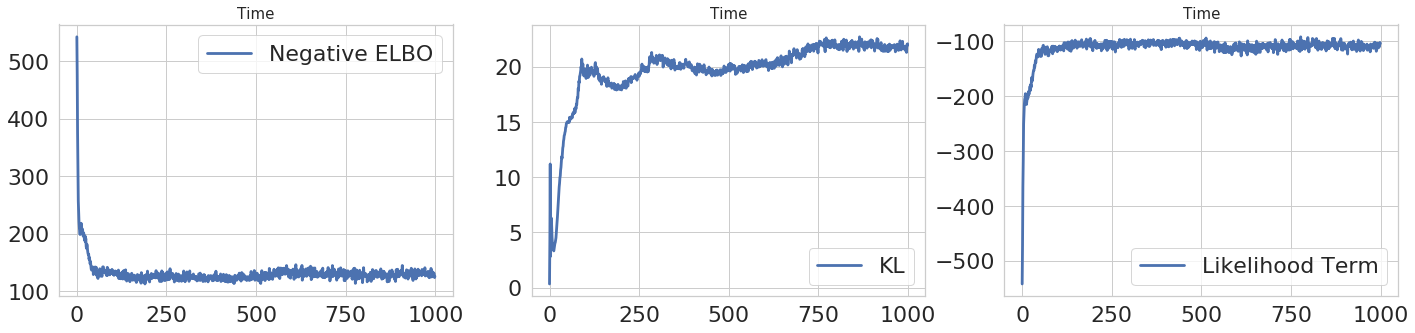

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples, reconstructions and latent interpolation

In [0]:
# Read data (just sample from the data set)
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

# Note: the reconstructions are only valid after the inner loop optimization has
# been performed.
reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
# Sample from the generative model!
def reset_ops():
  mean = (tf.ones(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32))
  scale = (tf.ones(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32))
  
  return mean, scale

variational_variables_reset_ops = reset_ops()


# For reconstructions, we run the inner loop updates first.
sess.run(data_assign_op)
  
# Reset the variational variables.
sess.run(variational_variables_reset_ops)

# Update the SVI variables.
for _ in range(1000):
  sess.run(variational_vars_update_op) 

(real_data_examples, data_reconstructions,
 variational_mean_val, variational_log_scale_val) = sess.run(
      [data_var, reconstructions, mean, scale])



final_samples = sess.run(samples)
print(real_data_examples.shape)

(64, 28, 28, 1)


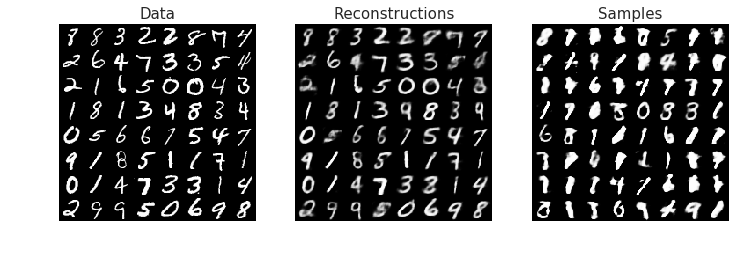

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))

show_digits(axes[0], real_data_examples, 'Data')
show_digits(axes[1], data_reconstructions, 'Reconstructions')
show_digits(axes[2], final_samples, 'Samples')

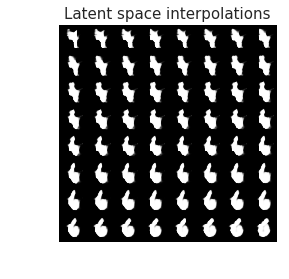

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.1 VI Questions (28 pts):

We going to go through some questions on the model you have just implemented. The first question here could be answered before the implementation and can act as a blue-print for how to do the training. We are going to spend a bit more time on this first method as it is paramount you understand the optimization process here as a lot of the other tasks build on top of this one. 

Whenever a question asks for an effect/behaviour when varying one of the conditions, feel free to experiment. Both theoretical arguments and emperical plots showing the relevant behaviour will be accepted here.

1. **[5 pts]**  Derive the variational ELBO for **one** data point $x$ and explain how one would update the parameters for variational posterior $q_{\phi}(z|x)$, as well as the parameters of the generative distribution $p_{\theta}(x|z)$. Assume a Gaussian prior and a multi-dim Gaussian variational prior, as well as the generative function given  by the decoder in the code above. This is basically outlining the optimization you should be implementing in the **Training loop** section above. 

**Answer**

>- For simplicity, I will use a simpler notation and exclude ${\theta}, {\phi}$ as it is pretty extra to add that in, in terms of latex.

>- The integral problem is that we want to find out what is $p(x)$ and therefore add in a latent variable, say $z$ and marginalise this out. Then apply Bayes rule, multiply by an equivalent of 1, apply commutative properties of multiplication and finally use Jensen's inequality.

$$\log(p(x)) = \log\int_Z p(x,z)dz $$
$$\log(p(x)) = \log\int_Z p(x,z)\frac{q(z|x)}{q(z|x)} dz $$
$$\log(p(x)) = \log\int_Z q(z|x)\frac{p(x,z)}{q(z|x)} dz $$
$$\log(p(x)) = \log\int_Z q(z|x)\frac{p(x|z)p(z)}{q(z|x)} dz $$
$$ \geq \mathbb{E}_{q(z|x)}[\log(\frac{p(x|z)p(z)}{q(z|x)})] $$
$$ =  \mathbb{E}_{q(z|x)}[\log(p(x|z)p(z)) - \log(q(z|x)))] $$
$$ =  \mathbb{E}_{q(z|x)}[\log(p(x|z) + \log(\frac{p(z)}{q(z|x)})] $$
$$ = \mathbb{E}_{q(z|x)}[\log(p(x|z)] + \mathbb{E}_{q(z|x)}[\log(\frac{p(z)}{q(z|x)})] $$
$$ = \mathbb{E}_{q(z|x)}[\log(p(x|z)]  + \int_{Z} q(z|x) \frac{p(z)}{q(z|x)} dz $$

$$ = \mathbb{E}_{q(z|x)}[\log(p(x|z)]  - KL(q(z|x) || p(z) ) $$


>- Using the same notation as **T1.1** we use $ \mathbb{E}_{p^{*}(x)} $, as the expected free energy under the distribution $p^{*}(x)$. We apply $ \mathbb{E}_{p^{*}(x)} $, and make use of linear properties of expectation to the final line in our derivation and we therefore get our objective that we want to maximise in **T1.1**.

$$ \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)}{\left[ \log p_\theta(x|z)\right]}  - \mathbb{E}_{p^*(x)}(KL(q(z|x)||p(z))) $$

>- To update parameters, since the conditional distributions are in exponential family form, we can exploit this and obtain a closed form solution. As suggested by the assignment, our 'decoder' represents $p_{\theta}(\mathbf{x}|\mathbf{z}) $. Using a bernoulli (denoted as $Bern$) distribution we intuitively assign a 'weight' to how much the latent variable $\mathbf{z}$  contributes to generating in some sense $\mathbf{x}$, using some function $f$ (in the assignment $f$ would be that CNN).

$$ p_{\theta}(\mathbf{x}|\mathbf{z}) \sim Bern(f(\mathbf{z}))$$

>- As a result, we take advantage of bayes rule and define a prior to be Gaussian (denoted as $Norm$) so that our variational posterior is:

$$ q_{\phi}(\mathbf{x}|\mathbf{z}) \sim Norm(f(\mathbf{x}), Trace[f(\mathbf{x})]) $$


2.  **[6 pts] **In the **Build the update operations for the variational and global variables**, I have define two separate optimizers for the two sets of parameters ($\theta$ and $\phi$). 
  * i)  How would you implement this with just one optimizer? (You just need to
explain how you would do it, but not implement).

**Answer**

>- We can use an auto-encoder and apply auto-encoding variational bayes (AEVB) algorithm that can efficiently solve inferencing and learning tasks. Specifically in our case the AEVB algorithm avoids the two-stage optimisation procedure and optimises a stochastic estimate of ELBO with respect to both parameters ($\theta$ and $\phi$). 


  * ii) What happen if we change the variational variables' optimizer `variational_vars_optimizer` to `tf.train.AdamOptimizer`? (Feel free to experiment and change the learning rate accordingly) 
  
**Answer**

>- By changing the optimiser what happens is that we converge so a local optimimum faster but we do not know if this is the correct optimum and when the code changed from SGD to Adam I get a posterior collapse where training results in a degenerate local optimum and ignores the latent variable and the approximate posterior mimics the prior.

>- In this scenario, empirically, we see that SGD is more optimal than Adam. The paper by Wilson et al. (2017) https://arxiv.org/abs/1705.08292 demonstrates that in our case SGD is better.

3. **[2 pts]** What are the computational considerents to think of when using SVI? What would happen if you would now want to train this SVI model on a big dataset, such as ImageNet? What part of this optimization process is mostly affected and in which way?

**Answer**

>- Computational considerations to think of when using SVI is the number of SVI updates (I've tested this on our task and concluded 10 updates was not enough) as well as what kind of optimiser you'd use. We have shown that it is not always necessarily effective to go by 'popular' optimisation methods such as Adam and it it preferable to go more traditional methods like SGD to obtain the correct representation. 

>- If we were to SVI model on ImageNet then this is computationally very expensive and would take too long for mother nature to compute since ImageNet has some really high feature dimension. The optimisation process that is most affected is constructing the variational ELBO. This is because for every datapoint i.e pixels since are updating the parameters for the variational posterior as well as the generative distribution.


4. ** [2 pts]**What is the effect of the number of SVI updates on the ELBO and on the KL term?

**Answer**

>- More SVI updates would **take significantly more time** this is because we repeat the update operations (by the number of SVI updates we choose) we are performing with whatever optimisation method we choose. 

>- If we don't have enough SVI updates, then KL-divergence tends towards zero. Meaning that our distributions are the same and will have a knock on effect of poor generalisation when decoding.


5. **[3 pts]** What is the effect of the data batch size on the convergence speed compared to the effect of the number of SVI updates? What is the effect of the number of training steps for the decoder compared to the number of SVI steps per decoder update?

**Answer**

>- A small batch size would increase the time taken to converge since at every iteration we feed in a small bit of the data and can therefore get gradient estimates which are quite noisy when we compare this to the number of SVI updates. But this is more tractable depending on the computational resources.

>- The effect of say increasing the number of training steps for the decoder more than SVI updates would make the algorithm run faster because how we model the posterior using Bayes rule and is therefore broken down into the likelihood under the latent variable $z$ and the prior. We are therefore optimising the decoder further towards the true distribution.


**[10 pts] Model Implementation and Results**

## T1.2 Amortized Variational Inference

**Reminder**: The idea behind amortized inference is to replace the slow iterative optimization process we needed to do in the previous method for each data-point, with a faster non-iterative one.  Check the lecture slides and/or references below for more details.

Thus, instead of learning one set of posterior variables per data point, we can use function approximation to learn the distributional variables. Specifically, the posterior parameters for $x_i$ will be the output of a *learned* function $f_\theta(x_i)$, where $\theta$ are parameters now shared across all data points. Can you think of why this is useful?


<h2 align="center"></h2> <img src="http://elarosca.net/vae.png?format=100w" width=500 >


Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} {\left[ \log p_\theta(x|z) \right]}  - \mathbb{E}_{p^*(x)} \left[ KL(q(z|x)||p(z)) \right]
\end{equation}

For more information, please check out: 
  * https://arxiv.org/abs/1312.6114


**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


### Define the encoder

In [0]:
ENCODER_VARIABLE_SCOPE = 'encoder'

In [0]:
def encoder(x):
  with tf.variable_scope(ENCODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    
    h = tf.layers.Conv2D(
          filters=8,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(x)
    h = tf.layers.Conv2D(
          filters=16,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=32,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    
    out_shape = 1
    for s in h.shape.as_list()[1:]:
      out_shape*= s
    
    h = tf.reshape(h, shape=[BATCH_SIZE, out_shape])
    mean = tf.layers.dense(h, NUM_LATENTS, activation=None)
    scale = tf.layers.dense(h, NUM_LATENTS, activation=None)
    return multi_normal(loc=mean, log_scale=scale)

### Define the prior

In [0]:
##################
# YOUR CODE HERE #
##################
prior = make_prior()

### Define the variational posterior
**Note**: We no longer have to use a variable to store the data. We will perform one encoder update per decoder update, so it is OK for the data batch to be refreshed at each run.

In [0]:
##################
# YOUR CODE HERE #
##################
variational_posterior = encoder(real_data)

### Define the decoder
We will use the same decoder as in T1.1

In [0]:
decoder = standard_decoder

### Define and build optimization objective (ELBO)

In [0]:
# Maximize the data likelihodd and minimize the KL divergence between the prior 
# and posterior. We use the exact same loss as in the SVI case.

##################
# YOUR CODE HERE #
##################
likelihood_term, kl_term = bound_terms(real_data, variational_posterior, decoder)
train_elbo = likelihood_term - kl_term
loss = -train_elbo

### Define optimization and the update operations

In [0]:
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)

##################
# YOUR CODE HERE #
##################
#amor_variational_vars = tf.get_collection(
#    tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)

update_op = optimizer.minimize(loss)

# Just to check
print("All trainable variables")
tf.trainable_variables()

All trainable variables


[<tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variab

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in xrange(TRAINING_STEPS):
  

  ##################
  # YOUR CODE HERE #
  ##################
  # Training, use update_op 
  
  #for j in xrange(NUM_SVI_UPDATES):
  
  sess.run([update_op])
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss 539.507751465. KL 0.0161630026996
Iteration 100. Loss 199.417984009. KL 5.21480464935
Iteration 200. Loss 182.667694092. KL 9.69737625122
Iteration 300. Loss 142.805053711. KL 15.0934677124
Iteration 400. Loss 139.50213623. KL 16.6482410431
Iteration 500. Loss 128.878448486. KL 17.1761112213
Iteration 600. Loss 122.436920166. KL 17.2655143738
Iteration 700. Loss 124.417861938. KL 17.8691368103
Iteration 800. Loss 118.653137207. KL 17.1194572449
Iteration 900. Loss 112.608406067. KL 17.3540935516
Iteration 1000. Loss 109.285675049. KL 17.848903656
Iteration 1100. Loss 111.940673828. KL 17.0832939148
Iteration 1200. Loss 120.084068298. KL 18.9300327301
Iteration 1300. Loss 111.685119629. KL 18.0362510681
Iteration 1400. Loss 112.536140442. KL 17.4628448486
Iteration 1500. Loss 108.048141479. KL 17.5381202698
Iteration 1600. Loss 116.08669281. KL 17.9747619629
Iteration 1700. Loss 112.19884491. KL 18.279045105
Iteration 1800. Loss 111.290557861. KL 18.4335632324
Iteratio

## Results

Let us take a look at the optimization process and the resulting model


### Visualize the loss in time

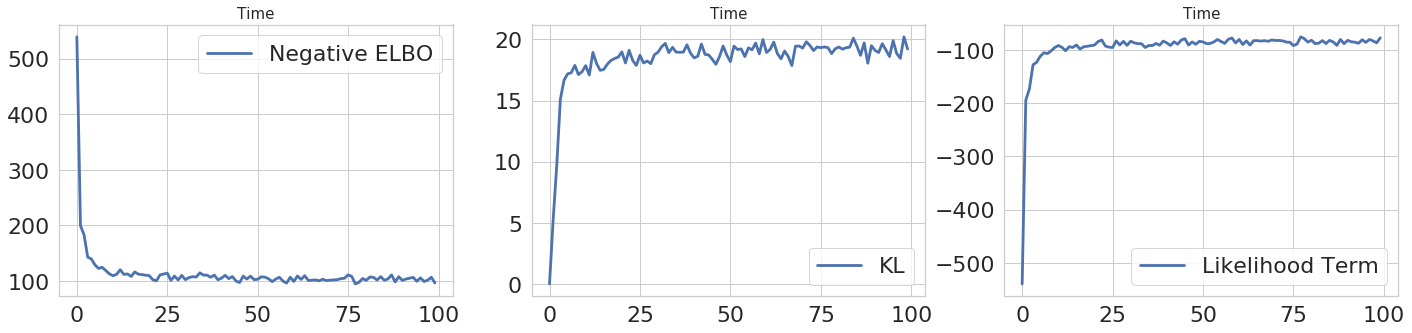

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples and latent interpolations

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

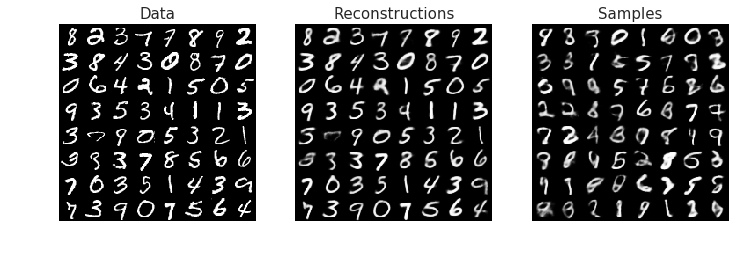

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

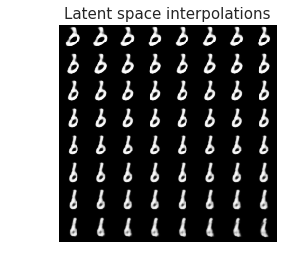

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.2 Questions about Amortized Variational Inference (15 pts)

1. **[5 pts]** What do you notice about amortized variational inference (especially as compared with stochastic variational inference)? 

  * i) Are there any downsides to using the amortized version?
  
  **Answer**
  
  >- Yes, according to Cramer et al. (2018) in their paper "Inference Suboptimality in Variational Autoencoders" they discuss a cost called the amortization gap. This gap is caused by the constraint imposed by our encoder variable, which is a neural network, to be able to map to the parameters which define the encoder variable.
  
  >- Intuitively, since we have some parameters $\mathbf{\theta}$ that are shared across all datapoints that means that representations share some similarities between digits. Empirically, in the reconstructions we see many digits looking like an "8" and what we are doing is therefore trading off computational complexity with the correct representation.
  
  * ii) What do you observe about sample quality and reconstruction quality? 
  
  **Answer**
  
  >- The reconstruction quality does a pretty good job in representing the actual data but misses out some specific things like on the last row, the second "2" from the left. The digit has lots of curves and these are flattened out due to the shared parameters.
  
  >- The sample quality is decent, this is evident when we look at the latent space interpolations and compare it to the vanilla SVI we can see a much clearer picture when moving left-to-right or top-to-bottom and can figure out what digit it is much clearly.
  
  
  * iii) What do you observe about the ELBO and KL term? \\
  
  **Answer**
  
  >- With ELBO it is the same as usual, cannot spot any significant differences.
  
  >- With KL term it is much more stable in a sense that we do not see much variation when we compare this to SVI.
  
(Here, feel free to vary parameters and compare with the T1.1)
2. **[4 pts]** Stochastic and amortized variational inference can be combined, leading to semi-amortized variational inference. Give an instance of an algorithm that would combine these and explain why that would be useful?

**Answer**

>- Semi-Amortized Variational Autoencoders. Kim et al (2018) in their paper "Semi-Amortized Variational Autoencoders" they explain that the algorithm would be useful as it would allow the use of advanced generative models without experience posterior collapse (a phenomena which causes our latent variable to mimic the prior) and the amortization gap as a result this method is like the middle ground between the two methods where AVI is fast in training/inference and SVI has minimal amortization gap.

3. **[1 pts]** What gradient estimation method is used to compute the gradients with respect to the encoder parameters?

**Answer**

>- In this assignment, Adam is our gradient estimation method with the learning rate 0.001, with beta_1=0.9 and  beta_2=0.9. It is not clear in the question if we are talking about in our implementation or in general. But generally what is used is Monte Carlo gradient estimation, Adagrad or SGD.


**[5 pts] Model Implementation and Results**

## T1.3 KL annealing

In this section we are going to be looking at the same model as in **T2.1**: same encoder + decoder, prior. But we are going to change slightly the optimization objective as given below.

Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)}  - \alpha \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation}

Where **$\alpha$ changes during training, to weigh in the KL term more**. In particular for our problem consider:
\begin{equation}
\alpha = \frac{n_{iter}}{N}
\end{equation}
where $n_{iter}$ is the number of training iterations we are have completed and $N$ is the total number of training iterations `TRAINING_STEPS`.

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)

In [0]:
prior = make_prior()
decoder = standard_decoder
encoder = encoder

##################
# YOUR CODE HERE #
##################
# variational_posterior = ... # Hint: From T2.1
variational_posterior = encoder(real_data)

### Define the KL coefficient $\alpha$ and its update function

In [0]:
##################
# YOUR CODE HERE #
##################
kl_coefficient = tf.Variable(0, name ='kl_coefficient', trainable = False, dtype = tf.float32)
kl_step = tf.constant(1/TRAINING_STEPS, name = 'kl_step')

update_kl_coeff = tf.assign(kl_coefficient, kl_coefficient + kl_step)

In [0]:
##################
# YOUR CODE HERE #
##################
# Hint: This very similar to what you've done in T1.2. Same model, 
# only slightly different loss including $\alpha$

likelihood_term, kl_term = bound_terms(real_data, variational_posterior, decoder)

train_elbo = likelihood_term - kl_coefficient*kl_term

loss = -train_elbo

In [0]:
# We now perform joint optimization on the encoder and decoder variables.
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)

##################
# YOUR CODE HERE #
##################
# Parameter update operation (as before)
variables_update_op = optimizer.minimize(loss)

# Ensure that a variable update is followed by an update in the KL coefficient.
with tf.control_dependencies([variables_update_op]):
  update_op = tf.identity(update_kl_coeff)

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss 539.926025391. KL 0.0219738073647
Iteration 100. Loss 200.821655273. KL 48.9211273193
Iteration 200. Loss 169.456314087. KL 47.9288711548
Iteration 300. Loss 133.003631592. KL 54.0165405273
Iteration 400. Loss 111.387184143. KL 62.1888656616
Iteration 500. Loss 109.050003052. KL 43.8603134155
Iteration 600. Loss 99.0347137451. KL 43.5664596558
Iteration 700. Loss 95.8162155151. KL 40.7499351501
Iteration 800. Loss 93.3513641357. KL 37.947303772
Iteration 900. Loss 94.0579605103. KL 36.005279541
Iteration 1000. Loss 102.011764526. KL 36.0293617249
Iteration 1100. Loss 88.5787582397. KL 34.5055923462
Iteration 1200. Loss 94.9123840332. KL 32.9964447021
Iteration 1300. Loss 91.5673980713. KL 33.1537818909
Iteration 1400. Loss 100.713661194. KL 32.3369827271
Iteration 1500. Loss 84.9807662964. KL 31.3997077942
Iteration 1600. Loss 89.7934036255. KL 30.9309806824
Iteration 1700. Loss 91.1839904785. KL 30.6985244751
Iteration 1800. Loss 90.349067688. KL 31.1862773895
Iterat

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL and likelihood over the training process (number of iterations)

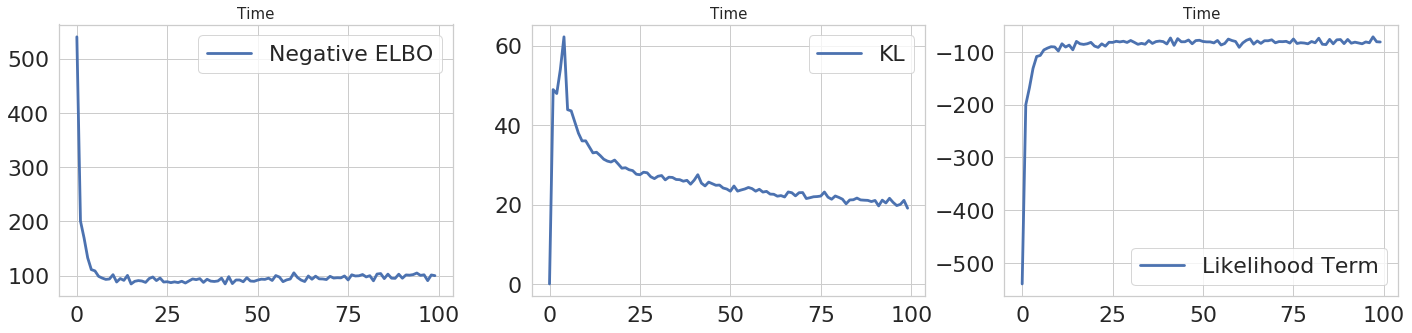

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples, reconstructions and latent interpolation

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

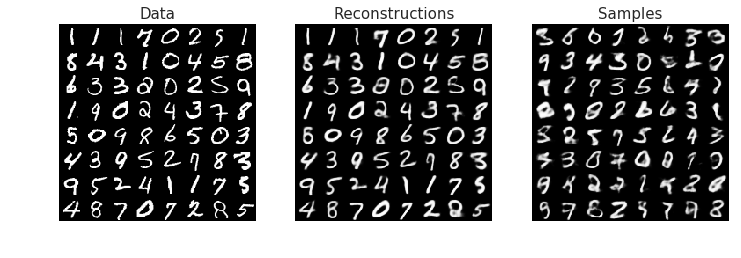

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

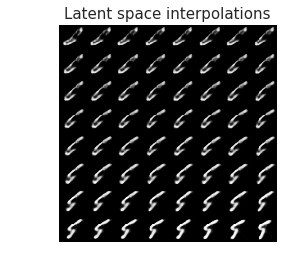

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.3 Questions about KL annealing (15 pts):

1. **[3 pts]** What do you observe about the KL behaviour throughout training as opposed to amortized variational inference without any KL annealing?

**Answer**

  >-  We get a large spike in the beginning and then starts to converge, when compared to AVI our KL term keeps decreasing and in AVI we get a plateau and looks relatively flat. This is because in KL annealing, we want to let the model learn to encode as much information as possible and as training progresses we start paying the full KL divergence penalty 
  
  
2.  **[1 pts]** How do the samples and reconstruction compare with the previous models?

**Answer** 

>- Our reconstructions aren't as crisp/clear as AVI but our samples look more accurate. 

3.  **[6 pts]** Consider now a schedule where $\alpha$ increases over time -- that is the contribution of the KL diminishes over time. When would that be a useful case? (Think about what this objective corresponds to in the optimization problem).

**Answer**

>- It will be useful to overcome the possibility of posterior collapse. In terms of the optimisation problem, Bowman et al. (2015) in their paper "Generating Sentences from a Continuous Space" mentions that a model that encodes useful information in the latent variable will have a non-zero KL-divergence. The vanilla VAE in their implementation failed to learn this behaviour. 

>- KL annealing allows the model to encode as much information as it can then by gradually increasing $\alpha$ it is intuitively smoothing out its encoding and store into the prior. By increasing $\alpha$ to $1$  the KL term is now equivalent to the usual ELBO.

**[5 pts] Model Implementation and Results**

## T1.4 Constrained optimization

In this next part, instead of using KL annealing, constrained optimization can be used to automatically tuned the relative weight of the likelihood and KL terms. This removes the need to manually create an optimization schedule, which can be problem specific.

The objective now becomes:

\begin{equation}
  \text{minimize } \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) \text{ such that }  \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} \left[ {\log p_\theta(x|z)} \right] > \alpha 
\end{equation}

This can be solved using the use of Lagrange multipliers. The objective becomes:

\begin{equation}
  \text{minimize }  \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) + \lambda  (\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z)))
\end{equation}


The difference compared to the KL annealing is that:

   * $\lambda$ is a learned parameter - it will be learned using stochastic gradient descent, like the network parameters.  The difference is that the lagrangian has to solve a maximization problem. You can see this intuitively: the gradient with respect to $\lambda$ in the objective above is $\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))$. If $ \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))> 0$, the constraint is not being satisfied, so the value of the lagrangian needs to increase. This will be done by doing gradient ascent, instead of gradient descent. Note that for $\lambda$ to be a valid lagranian in a minimization problem, it has to be positive.
   * The practicioner has to specify the hyperparameter $\alpha$, which determines the reoncstruction quality of the model.
   * the coefficient is in front of the likelihood term, not the KL term. This is mainly for convenience, as it is easier to specify the hyperparameter $\alpha$ for the likelihood (reconstruction loss).


For more assumptions made by this method, see the Karush–Kuhn–Tucker conditions.

For more information, see: 
  * http://bayesiandeeplearning.org/2018/papers/33.pdf

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)

In [0]:
prior = make_prior()
decoder = standard_decoder
encoder = encoder

##################
# YOUR CODE HERE #
##################
variational_posterior = encoder(real_data) # Hint: From T2.1

### Define the lagrangian variable $\lambda$.
Unlike in the KL annealing case, we learn the coefficient. Remember that this variable has to be always positive. To ensure this, use `tf.nn.softplus`, Moreover, please initialize the lagrangian such that after the softplus the coefficient is approximately 1. Check emperically that this is true when instantiating the variable.

In [0]:
##################
# YOUR CODE HERE #
##################
lagrangian_var = tf.Variable(initial_value = 0.4, name ='langrangian_var', trainable = True, dtype = tf.float32)

# Ensure that the lagrangian is positive and has stable dynamics.
lagrangian = tf.nn.softplus(lagrangian_var)

In [0]:
# How good do we want the reconstruction loss to be?
# We can look at previous runs to get an idea what a reasonable value would be.

##################
# YOUR VALUE HERE#
##################

reconstruction_target = tf.Variable(-83, name = "reconstuction", trainable = False, dtype = tf.float32)

# Varying the reconstruction target
#reconstruction_target = tf.Variable(-183, name = "reconstuction", trainable = False, dtype = tf.float32)

### Define the loss

In [0]:
##################
# YOUR CODE HERE #
##################
likelihood_term, kl_term = bound_terms(real_data, variational_posterior, decoder)
loss =  kl_term + lagrangian * (reconstruction_target - likelihood_term )

In [0]:
# Check trainable variables (the lagrangian variable should be in here)
tf.trainable_variables()

[<tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'langrangian_var:0' shape=() dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose

In [0]:
lagrangian_optimizer = tf.train.GradientDescentOptimizer(0.001)

##################
# YOUR CODE HERE #
##################

decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)

autoencoder_variables_update_op = optimizer.minimize(loss, var_list=[encoder_vars, decoder_vars])

# Ensure that a variable update is followed by an update to the Lagrangian.
with tf.control_dependencies([autoencoder_variables_update_op]):
  # Ensure that the lagrangian solves a maximization problem instead of a
  # minimization problem by changing the sign of the loss function.
  update_op = lagrangian_optimizer.minimize(- loss, var_list=[lagrangian_var])

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []
lagrangian_values = []

for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl, lag_val  = sess.run(
          [loss, likelihood_term, kl_term, lagrangian])
    print('Iteration {}. Loss {}. KL {}. Lagrangian {}'.format(
          i, iteration_loss, iteration_kl, lag_val))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)
    lagrangian_values.append(lag_val)

Iteration 0. Loss 496.810394287. KL 0.00410275533795. Lagrangian 1.08702540398
Iteration 100. Loss 2313.64306641. KL 22.6547317505. Lagrangian 18.9856796265
Iteration 200. Loss 2706.96264648. KL 38.2990760803. Lagrangian 29.796459198
Iteration 300. Loss 1686.82397461. KL 55.4275932312. Lagrangian 36.6017379761
Iteration 400. Loss 979.55645752. KL 58.7461013794. Lagrangian 40.1306533813
Iteration 500. Loss 737.243041992. KL 59.7360229492. Lagrangian 42.4378013611
Iteration 600. Loss 230.04598999. KL 55.8201370239. Lagrangian 44.1037597656
Iteration 700. Loss 351.188140869. KL 58.9907264709. Lagrangian 45.4593925476
Iteration 800. Loss 789.553771973. KL 58.1680984497. Lagrangian 46.5979003906
Iteration 900. Loss 439.213500977. KL 54.5350418091. Lagrangian 47.5184364319
Iteration 1000. Loss 551.612915039. KL 54.5095748901. Lagrangian 48.285446167
Iteration 1100. Loss 575.184020996. KL 54.0673980713. Lagrangian 48.9476852417
Iteration 1200. Loss 860.686279297. KL 50.4272155762. Lagrangian 

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL over the training process (number of iterations)

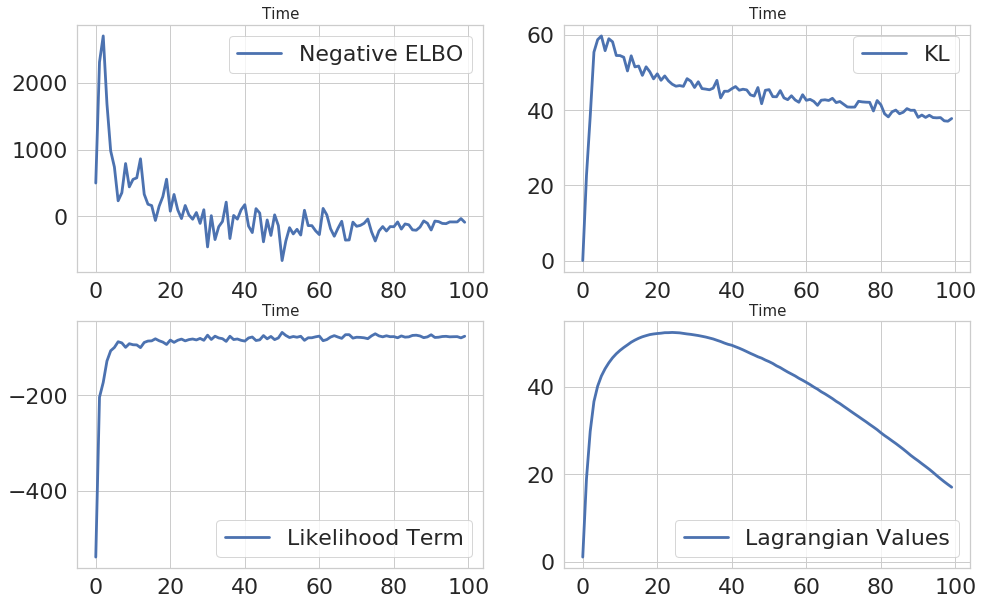

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(2*8, 2* 5))

axes[0, 0].plot(losses, label='Negative ELBO')
axes[0, 0].set_title('Time', fontsize=15)
axes[0, 0].legend()

axes[0, 1].plot(kls, label='KL')
axes[0, 1].set_title('Time', fontsize=15)
axes[0, 1].legend()

axes[1, 0].plot(likelihood_terms, label='Likelihood Term')
axes[1, 0].set_title('Time', fontsize=15)
axes[1, 0].legend()

axes[1, 1].plot(lagrangian_values, label='Lagrangian Values')
axes[1, 1].set_title('Time', fontsize=15)
axes[1, 1].legend()

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

### Generate samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

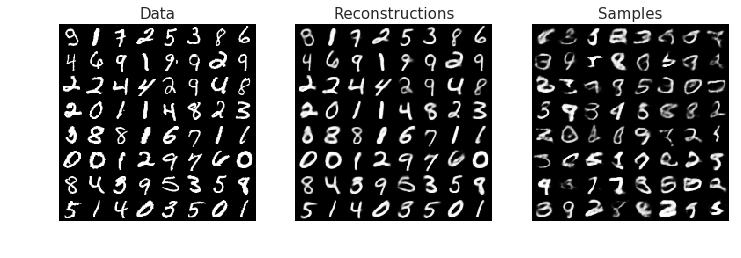

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

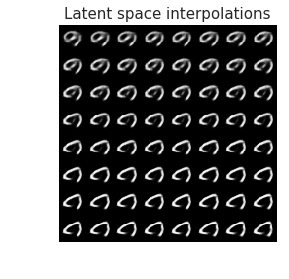

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q4.1 Questions about constrained optimization (12 pts)

1.  **[3 pts]** Based on previous results, set and try varying the threshold for reconstruction (variable `reconstruction_target` int the code above). Describe what happens when you vary this variable. (Produce the plots to support your answer)

**Answer**

>- Specifically I set the value to say "-137" and when I did i experience posterior collapse, the below images are for when I set this value.

[![Image from Gyazo](https://i.gyazo.com/ff365e8844a04411276b4d9f6d94fce9.png)](https://gyazo.com/ff365e8844a04411276b4d9f6d94fce9)

[![Image from Gyazo](https://i.gyazo.com/6e6744da7393fdbc2b6b08afa2fbf75d.png)](https://gyazo.com/6e6744da7393fdbc2b6b08afa2fbf75d)

>- What we are experiencing is very close to or is posterior collapse. This is because our latent representations in our reconstructions and our samples are very blurry and we can only distinguish a few values such as zeros. This is because our reconstruction target is dominating optimisation as discussed in [http://bayesiandeeplearning.org/2018/papers/33.pdf](http://bayesiandeeplearning.org/2018/papers/33.pdf).

2.  **[1 pts]** What do you observe about the behaviour of the likelihood and KL term throughout training? How is it different than in Stochastic Variational Inference and Amortized Variational inference with and without KL annealing?

**Answer**

>- The KL term increases largely and then slowly decreases over time, when compared to KL annealing we see a large jump, same as CO (constrained optimisation) but a large decrease in KL and then a plateau. 

>- Similary, comparing to SVI, AVI the look like the inverse of KL annealing and increase over time with a shape increase at the beginning and then a plateau. CO is completely different.

>- When we look at the likelihood terms, all models show very similar trend of likelihood terms and similar bounds on the y-axis.

3.  **[3 pts]** What do you notice about the behaviour of the lagrangian during training? Is that what you expected?

**Answer**

>- Lagrangian explodes massively during the first 20 iterations and subsequently slowly declines are more iterations are passed almost similar to KL. This is what I expected since we inistialise $\alpha$ to be some negative value, we need a larger $\lambda$ to satisfy our optimisation criteria and as we train this decreases since we update paramters and obtain new new terms to iteratively optimise over.


**[5 pts] Model Implementation and Results**

# Part 2: Reconstruction-free Generative Models

##  T2.1 Generative Adversarial Networks

So far we have discussed variational inference models, which learn how to match the marginal distribution $p_\theta(x)$, learned by the model, with the true data distribution $p^\star(x)$ through the variational lower bound. This approach uses latent variables and requires that the conditional posterior distributions cover the prior space; otherwise the decoder will not be able to generalise to prior samples which are unlike what it has seen during training. 


To avoid this issue, some methods directly match $p_\theta(x)$ learned by the model with the true data distribution $p^\star(x)$. Such an approach is given by generative adversarial networks (GANs).

Generative adversarial networks optimize an adversarial two-player game given by the value function:
\begin{equation}
\max_{G} \min_{D} \mathbb{E}_{p^*(x)} \log D(x) + \mathbb{E}_{p(z)} \log (1- D(G(z)))
\end{equation}
where $G$ is the generator (as before this takes a latent sample $z$ and produce a image $x_{gen}$) and $D$ denotes the discriminator. 

A depiction of the model can be found below:

<h2 align="center"></h2> <img src="http://elarosca.net/gan.png?format=100w" width=210 >

For more information, see: 
  * https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf
  * https://arxiv.org/abs/1701.00160

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.


## Q2.1 Prelimary questions (5 pts)

Before trying to implement this generative model, let us take a closer look at its components and how one can train them. 
*  **[2 pts]** First thing to note is that now we have two models to train: a generative model $G$ and a discriminative model $D$. How does one train these two models in the (standard) GAN formulation? Give the update rules and losses for each these ($D$ and $G$). Which of these losses uses the generated data and which of them uses the real data.

**Answer**

>- The update rules are:

$$ \underset{G}{\operatorname{min}}\underset{D}{\operatorname{max}} Loss(D,G) = \mathbb{E}_{x}[\log(D(x))] + \mathbb{E}_{z}[1-\log(D(G(z)))] $$ 

>- The loss for $D$ is $ \mathbb{E}_{x}[\log(D(x))] $ and the loss for $G$ is $\mathbb{E}_{z}[1-\log(D(G(z)))] $. the loss for $D$ is the model which uses real data. Whereas the loss for $G$ is the one that uses generated data. $x$ means the real data and $z$ means the generated data.

>- To train the GAN: For $G$ is to maximise the probability of $D$ making a mistake. Similarly the goal for $D$ is to maximise the predictions $D$ makes. $G$ and $D$ are usually a neural network and can be trained using usual method of backpropagation with an appropriate optimiser like Adam (in our implementation).

*  **[3 pts]** [Generator loss] Instead of using the generator loss above, in practice we often use a surrogate,  $- \log D(G(x))$. Why do you think that is the case? Plot the original loss and associated gradients. Then plot the surgate loss $- \log D(G(x))$ and its associated gradients.

**Answer**

>- We use $- \log D(G(x))$ since the original generator loss is difficult to train in terms of convergence. In the GAN paper (2014) they use a surrogate because they proved that using $- \log D(G(x))$ obtains convergence, see page 5 in the GAN paper. [https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)


## Model Implementation

In [0]:
tf.reset_default_graph()

### Get and rescale the data

Scale the data between -1 and 1. This helps training stability and improves GAN convergence.

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
real_data = 2 * real_data - 1

In [0]:
print(real_data.shape)

(?, 28, 28, 1)


### Define the discriminator and generator networks

We will use the same network as the VAE decoder for the generator. The only difference is that the generator here is implicit - it does not define a probability distribution over pixels. Since the input data is scaled to be between -1, and 1, the generator output range will be the same, by using a tanh output non-linearty.

In [0]:
DISCRIMINATOR_VARIABLE_SCOPE = 'discriminator'
GENERATOR_VARIABLE_SCOPE = 'generator'

In [0]:
def discriminator(x):
  with tf.variable_scope(DISCRIMINATOR_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = x
    h = tf.layers.Conv2D(
          filters=8,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(x)
    h = tf.layers.Conv2D(
          filters=16,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=64,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=64,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h) 
    
    out_shape = 1
    for s in h.shape.as_list()[1:]:
      out_shape*= s
    
    h = tf.reshape(h, shape=[BATCH_SIZE, out_shape])
    logits = tf.layers.dense(h, 1, activation=None)
    return logits
    

In [0]:
def generator(z):
  with tf.variable_scope(GENERATOR_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.nn.tanh(h)

## Generate samples

In [0]:
##################
# YOUR CODE HERE #
##################
# To generate samples, we use a prior and sample from that and use the generator to produce an
# output between -1,1
prior = make_prior()
samples = generator(prior.sample())

## Set up the adversarial game

### Discriminator loss

In [0]:
##################
# YOUR CODE HERE #
##################
# Since discriminator outputs logits, we need to return the probabilities
# using "tips and tricks" section from https://arxiv.org/pdf/1701.00160.pdf
D_real = discriminator(real_data)
D_fake = discriminator(samples)

# Reduce loss over batch dimension
discriminator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real)) + 
                                    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake)))

### Generator loss

In [0]:
##################
# YOUR CODE HERE #
##################
generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))

In [0]:
tf.trainable_variables()

[<tf.Variable 'generator/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'generator/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_transpose/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_transpose_1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'generator/conv2d_transpose_1/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'discriminator/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>,
 <tf.Variable 'discriminator/conv2d/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'discriminator/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>,
 <tf.Variable 'discriminator/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'discriminator/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'discriminator/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf

### Create optimizers and training ops

**Important**: You will need to pass the list of variables to the TensorFlow optimizer, otherwise the generator and discriminator
variables will receive both the loss of the discrimiantor and that of the generator. 

We want to freeze the discriminator when we update the generator, and vice versa.

In [0]:
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)
generator_optimizer = tf.train.AdamOptimizer(0.0003, beta1=0.9, beta2=0.9)

# Optimize the discrimiantor.
discriminator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DISCRIMINATOR_VARIABLE_SCOPE)
discriminator_update_op = discriminator_optimizer.minimize(
    discriminator_loss, var_list=discriminator_vars)

# Optimize the generator.
generator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=GENERATOR_VARIABLE_SCOPE)
generator_update_op = generator_optimizer.minimize(
    generator_loss, var_list=generator_vars)

## Training


### Create the tensorflow session

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

### Training Loop

We train the discriminator and generator by alternating gradient descent runs. We record the losses to plot them later.

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
disc_losses = []
gen_losses = []

for i in xrange(TRAINING_STEPS):
  sess.run(discriminator_update_op)
  sess.run(generator_update_op)
  
  if i % 100 == 0: 
    disc_loss = sess.run(discriminator_loss)
    gen_loss = sess.run(generator_loss)
    
    print('Iteration: {}. Disc loss: {}. Generator loss {}'.format(
          i, disc_loss, gen_loss))
  
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)

Iteration: 0. Disc loss: 1.37122917175. Generator loss 0.692542254925
Iteration: 100. Disc loss: 0.215890929103. Generator loss 1.6644898653
Iteration: 200. Disc loss: 0.0350714698434. Generator loss 4.35166072845
Iteration: 300. Disc loss: 4.83731746674. Generator loss 10.8775157928
Iteration: 400. Disc loss: 0.0563729330897. Generator loss 3.37882614136
Iteration: 500. Disc loss: 0.000283240049612. Generator loss 9.14104652405
Iteration: 600. Disc loss: 0.00223104516044. Generator loss 6.73695755005
Iteration: 700. Disc loss: 2.73207388091e-05. Generator loss 10.5432386398
Iteration: 800. Disc loss: 0.66520100832. Generator loss 0.815776467323
Iteration: 900. Disc loss: 0.700638890266. Generator loss 1.46104502678
Iteration: 1000. Disc loss: 0.826993107796. Generator loss 0.72069811821
Iteration: 1100. Disc loss: 0.606721401215. Generator loss 0.888466060162
Iteration: 1200. Disc loss: 0.309745788574. Generator loss 1.85570693016
Iteration: 1300. Disc loss: 0.136369094253. Generator 

## Results

### Visualize the behaviour of the two losses during training

Note that unlike losses for classifiers, or for VAEs, the losses are not stable and are going up and down, depending on the training dynamics. 

Text(0.5,-0.2,'Generator loss')

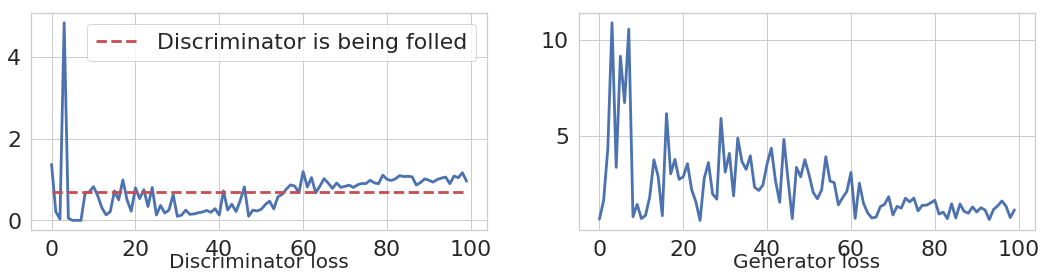

In [0]:
figsize = (18, 4)
fig, axs = plt.subplots(1, 2, figsize=figsize)


# First plot the loss, and then the derivative.
axs[0].plot(disc_losses, '-')
axs[0].plot([np.log(2)] * len(disc_losses), 'r--', label='Discriminator is being folled')
axs[0].legend()
axs[0].set_title('Discriminator loss', fontsize=20, y=-0.2)
axs[1].plot(gen_losses, '-')
axs[1].set_title('Generator loss', fontsize=20, y=-0.2)

### Generate and plot samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals  = sess.run([real_data, samples])

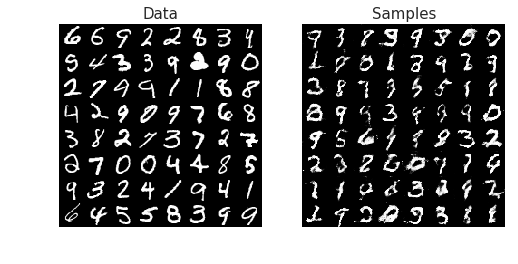

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(2*4,4))

show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], final_samples_vals, 'Samples')

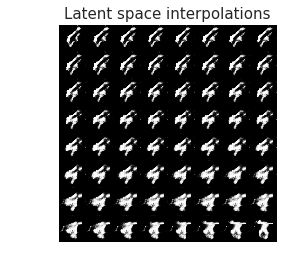

In [0]:
show_latent_interpolations(generator, prior, sess)

### Q2.2 GAN Questions (25 pts):  
1.  **[3 pts]** In defining the optimization procedure above (Section **Create optimizers and training ops**) we opted for two optimizer one for the discriminator and one for the generator. Is this necessary? Why would this be a good/bad idea in general? 

**Answer**

>- We usually need to have two optimizers. This is necessary because the discriminator and generator are intuitively the opposite of each other and they both have parameters to optimise over and their losses are inherently different. The preliminary task highlights the losses and therefore it would be better to train two optimisers with a different set of parameters for each one so that we have more flexibility in choosing the parameters since GANs are very sensitive to the parameters of optimisation process and can get stuck in local minima or in an intuitive sense, stuck in local equilibria in a the non-convex game they play and as a result, the generator or discriminator will not converge as they have not reached the optimum equilibrium. 

>- In general, using one optimizer will be sub-optimal as you are therefore limit the number of parameters in the optimisation process and can get stuck in local optimums more, than otherwise using two optimizers.

2.  **[3 pts]** Discuss the hyperparameter sensitivy of GANs compared to that of VAEs. (What happens to the model if you use a higher learning rate for the discriminator or the generator?)

**Answer**

>- In GANs, there are several research papers that conclude that GANs are very unstable during training and very sensitive to the choice of hyper parameters when optimising over a given method. If we were to use a larger learning rate, then our loss for both the discriminator converges to some point and as a result we run into problems such as mode collapse, vanishing gradients. If we look at VAEs, generally they are more stable to changes to hyper parameters, though we can still get posterior collapse in VAEs.


3.  **[2 pts]** When would you want to use GANs and when would you want to use VAEs? Which of the following can be performed using VAEs, and which can be performed using GANs: density estimation, representation learning, data generation?

**Answer**

>- VAEs are more suitable density estimation, representation learning but are also not limited to data generation.

>- GANs are more suitable for data generation. 

>- However, when you want to use VAEs vs GANs depends on application. For example, VAEs would be useful when you want to learn a representation of the data as Dumoulin et al. (2014) explain that VAEs provide interpretable latent variables and require a few dimensions. 

>- You would want to use a GAN when you are sure that posterior collapse is present as this type of model would overcome this and gives more realistic results. However GANs are susceptible to the "missing modes" problem where there are many modes of data generating distributions which are not at all represented in the generated samples.

4.  **[2 pts]** What do you observe about GAN samples compared to VAE samples?

**Answer**

>- GANs look less smoother/smudged and looks a lot more like as if we are writing digits in chalk so therefore more realistic in my opinion when compared to VAEs. This is because GANs sample noise using some distribution and utilises the generator G to output an image while VAE creates samples from a generated probability distribution.

5.  **[3 pts]** What happens if you optimize the GAN discriminator 5 times per generator update? (This will become particularly relevant for next part) 

**Answer**

>-  This can cause the vanishing gradient problem and therefore our discriminator will become too good and the generator gradient would vanish and would learn nothing as a result of over optimising the discriminator.

6.  **[2 pts]** What happens if you optimize the GAN generator 10 times per discriminator update?

**Answer**

>- If we optimise the generator more then the discriminator would most likely lead to a single modal collapse i.e the generator could converge to find some small variety of samples that would fool the discriminator. On the other hand, if we look at the discriminator when we optimise GANs, the discriminator would learn a single mode to detect the generated images and therefore in some sense "overfitting" and failing to detect other samples when the generator does create very different image. In addition, the volatile nature of GANs make this very hard and it is plausible to say that we converge to some local minima and we learn nothing in general.

**[10 pts] Model Implementation and Results**


# ===== END OF GRADED COURSEWORK ========

## T2.2 [Optional] Wasserstein GAN

Since the proposal of the original GAN, multiple objectives have been proposed, inspired by different learning principles. In Wasserstein GAN, optimal transport is used to create the training criteria:
\begin{equation}
  \sup_{||f||_{L \leq 1}} \mathbb{E}_{p^*(x)} f(x) - \mathbb{E}_{p_(z)} f(G(z))
\end{equation}
where $||f||_{L \leq 1}$ denotes the family of 1-Lipchitz functions.

Due to the intractability of the supremum in the equation above, the WGAN value function is constructed from the optimal transport criteria using the Kantorovich-Rubinstein duality:
\begin{equation}
  \min_{G} \max_{D}  \mathbb{E}_{p^*(x)} D(x) - \mathbb{E}_{p_(z)} D(G(z))
\end{equation}

where $D$ is a 1-Lipchitz function. The Lipchitz constraint is imposed using gradient penalties on the discriminator. 

For extra reading, see:
 * https://arxiv.org/abs/1701.07875
 * https://arxiv.org/abs/1704.00028


**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

### Define the gradient penalty

In [0]:
def batch_l2_norms(x, eps=1e-5):
  reduction_axis = range(1, x.get_shape().ndims)
  squares = tf.reduce_sum(tf.square(x), axis=reduction_axis)
  squares.get_shape().assert_is_compatible_with([None])
  return tf.sqrt(eps + squares)

def wgan_gradient_penalty(discriminator, real_data, samples):
  """The gradient penalty loss on an interpolation of data and samples.

  Proposed by https://arxiv.org/pdf/1704.00028.pdf for Wasserstein GAN, but
  recently becoming more widely adopted, outside the Wasserstein setting.

  Args:
    discriminator: An instance of `AbstractDiscriminator`.
    real_data: A `tf.Tensor` (joint discriminator `tf.Tensor` sequences are not
      yet supported). The data associated as real by the GAN, usually from a
      datasets. Needs to be a valid input for `discriminator`.
    samples: A `tf.Tensor` or `tf.Tensor` sequence (for joint discriminators).
      Samples obtained from the model. Needs to be a valid input for
      `discriminator`.

  Returns:
    A `tf.Tensor` scalar, containing the loss.
  """

  ##################
  # YOUR CODE HERE #
  ##################

### Get and rescale the data

Scale the data between -1 and 1. This helps training stability and improves GAN convergence.

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
real_data = 2 * real_data - 1

### Generate samples

In [0]:
##################
# YOUR CODE HERE #
##################
# samples = 

## Set up the adversarial game

### Discriminator and generator loss

In [0]:
# The weight of the gradient penalty
GRADIENT_PENALTY_COEFF = 10

In [0]:
##################
# YOUR CODE HERE #
##################
# discriminator_loss = 
# generator_loss = 

### Create optimizers and training ops



In [0]:
discrimiantor_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)
generator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)

# Optimize the discrimiantor.
discriminator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DISCRIMINATOR_VARIABLE_SCOPE)
discriminator_update_op = discrimiantor_optimizer.minimize(
    discriminator_loss, var_list=discriminator_vars)

# Optimize the generator.
generator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=GENERATOR_VARIABLE_SCOPE)
generator_update_op = generator_optimizer.minimize(
    generator_loss, var_list=generator_vars)

ValueError: ignored

## Training

We train the discriminator and generator by alternating gradient descent runs. We record the losses to plot them later.

### Create the tensorflow session

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [0]:
NUM_DISC_UPDATES_PER_GEN_UPDATE = 5

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
disc_losses = []
gen_losses = []

for i in xrange(TRAINING_STEPS):
  # Do multiple discriminator updates per generator update. 
  for _ in xrange(NUM_DISC_UPDATES_PER_GEN_UPDATE):
    sess.run(discriminator_update_op)
  sess.run(generator_update_op)
  
  if i % 100 == 0: 
    disc_loss = sess.run(discriminator_loss)
    gen_loss = sess.run(generator_loss)    
  
    print('Iteration: {}. Disc loss: {}. Generator loss {}'.format(
          i, disc_loss, gen_loss))
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)

## Results

### Visualize the behaviour of the two losses during training

Note that unlike losses for classifiers, or for VAEs, the losses are not stable and are going up and down, depending on the training dynamics. 

In [0]:
figsize = (20, 6)
fig, axs = plt.subplots(1, 2, figsize=figsize)


# First plot the loss, and then the derivative.
axs[0].plot(disc_losses, '-')
axs[0].plot([0.] * len(disc_losses), 'r--', label='Discriminator is being folled')
axs[0].legend()
axs[0].set_title('Discriminator loss', fontsize=20, y=-0.2)
axs[1].plot(gen_losses, '-')
axs[1].set_title('Generator loss', fontsize=20, y=-0.2)

### Generate samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals  = sess.run([real_data, samples])

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(2*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], final_samples_vals, 'Samples')

In [0]:
show_latent_interpolations(generator, prior, sess)

## Questions about WGANs:

* What happens if you optimize the original GAN discriminator 5 times per generator update - like in Wasserstein GANs? What happens if you train the Wassterstein GAN with 1 discriminator update per generator update?
* Can you think of a general recipe to create a new type of GAN loss?
